In [1]:
# Copyright (c) 2024 Graphcore Ltd. All rights reserved.

from matplotlib import pyplot as plt
import numpy as np
from gfloat import *
from gfloat.formats import format_info_ocp_e5m2

# Stochastic rounding

This notebook does some simple experiments with stochastic rounding.

The first is to plot the mean rounded value for a relatively small number of bits (2 bits). 

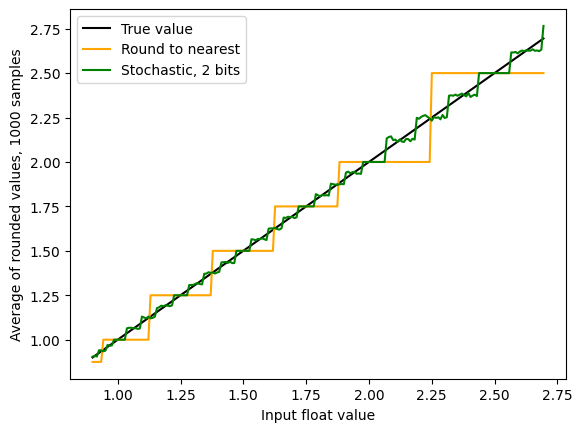

In [9]:
fi = format_info_ocp_e5m2

vs = np.arange(0.9, 2.7, 1.0 / 117)
# Round to nearest
rn = round_ndarray(fi, vs)

# Stochastic rounding
srnumbits = 2
rvs = np.zeros_like(vs)
nsamples = 1000
for n in range(nsamples):
    srbits = np.random.randint(0, 2**srnumbits, vs.shape)
    rvs += [
        round_float(
            fi, v, RoundMode.Stochastic, sat=False, srbits=srbits, srnumbits=srnumbits
        )
        for v, srbits in zip(vs, srbits)
    ]
rvs /= nsamples

plt.plot(vs, vs, label="True value", color="k")
plt.plot(vs, rn, label="Round to nearest", color="orange")
plt.plot(vs, rvs, label=f"Stochastic, {srnumbits} bits", color="green")
plt.xlabel("Input float value")
plt.ylabel(f"Average of rounded values, {nsamples} samples")
plt.legend()

We can see that, in simple terms, the orange (pale) line is closer to the black line than the (darker) green line.  That is, on average, stochastic rounding preserves accuracy that other roundings do not.